In [1]:
import scipy.io
import collections
import numpy as np
from theano import config, shared
from sklearn import preprocessing


def mackey_glass(sample_len=1000, tau=17, seed=None, n_samples = 1):
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    delta_t = 10
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples

x = mackey_glass(sample_len=2500)
x = np.squeeze(x)[:,np.newaxis]
x = np.array(preprocessing.MinMaxScaler(feature_range=(0.1, 0.9)).fit_transform(x), config.floatX)


N = len(x)
s_noise = 0.5
nu = np.random.randn(N,) * s_noise

n = 0
m = n + (N // 2)
w = 1
y_train = x[n+w:m+w]
X_train = x[n:m]

n = m + 1
m = N - w - 1
y_test = x[n+w:m+w]
X_test = x[n:m]

<IPython.core.display.Javascript object>


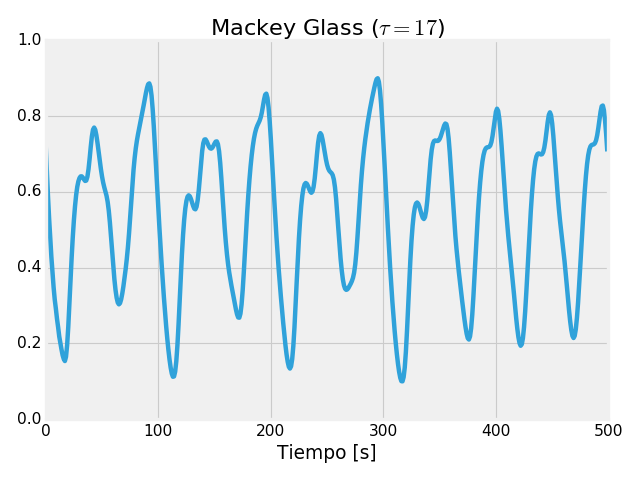

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

t = np.linspace(0, 499, 500)
plt.plot(t, X_train[0:500,0])
plt.title('Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')
plt.tight_layout()

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../../'))

from deepensemble.utils.utils_functions import ActivationFunctions
from deepensemble.models.sequential import Sequential
from deepensemble.layers.dense import Dense
from deepensemble.layers.recurrent import RecurrentLayer
from deepensemble.models.ensemblemodel import EnsembleModel
from deepensemble.combiner import *
from deepensemble.metrics import *
from deepensemble.utils import *

n_neurons = 12
n_models = 4
lr = 0.005
batch_size = 50
max_epoch = 300

n_ensemble_models = 5

fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.sigmoid

n_features = X_train.shape[1]

n_output = y_train.shape[1]
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

s = ITLFunctions.silverman(np.array(y_train)).eval()
print('Silverman: %0.4g' % s)

Silverman: 0.05271


In [4]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble',
                                  n_input=n_features, n_output=n_output,
                                  n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                                  fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                  cost=mse, name_cost="MSE",
                                  params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Start Compile Ensamble  - elapsed: 1.80 [s]
Ensamble - fold: 1, epoch:[####################] 300/300 elapsed: 2.08[s] - left: 0.00[s] | score: 0.0012 / 0.0015
FINISHED!


In [5]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL',
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.8, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Start Compile Ensamble NCL  - elapsed: 8.44 [s]
Ensamble NCL - fold: 1, epoch:[####################] 300/300 elapsed: 3.82[s] - left: 0.00[s] | score: 0.0013 / 0.0015
FINISHED!


In [6]:
# Create MLP
mlp = get_mlp_model("MLP (%d neuronas)" % (n_neurons_model * n_ensemble_models),
                           n_input=n_features, n_output=n_output,
                           n_neurons=n_neurons_model,
                           fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                           cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Start Compile MLP (5 neuronas)  - elapsed: 0.35 [s]
MLP (5 neuronas) - fold: 1, epoch:[####################] 300/300 elapsed: 0.92[s] - left: 0.00[s] | score: 0.0086 / 0.0097
FINISHED!


In [7]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIP',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.3, lamb=0.3, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=lr,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -lr})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=True)
                      
# training
metrics = ensembleCIP.fit(X_train, y_train, max_epoch=max_epoch, batch_size=batch_size, early_stop=False,
                         criterion_update_params='score', maximization_criterion=False)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Start Compile Ensamble CIP  - elapsed: 55.40 [s]
Ensamble CIP - fold: 1, epoch:[####################] 300/300 elapsed: 45.83[s] - left: 0.00[s] | score: 0.0249 / 0.02581
FINISHED!


In [8]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleCIP = ensembleCIP.score(X_test, y_test)
score_train_ensembleCIP = ensembleCIP.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble: 0.001249 / 0.001245
Ensamble NCL: 0.001260 / 0.001255
Ensamble CIP: 0.011843 / 0.011788
MLP: 0.008668 / 0.008633


<IPython.core.display.Javascript object>


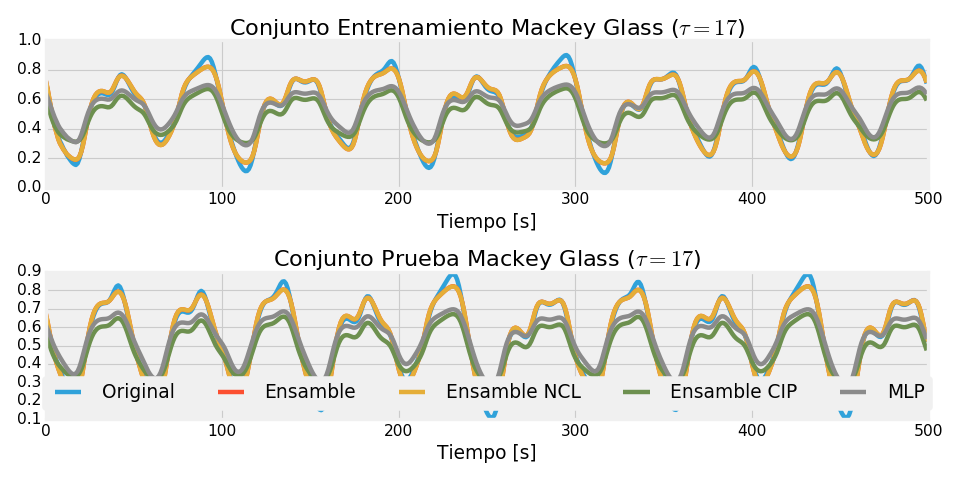

In [9]:
# plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 6), dpi=80)

t = np.linspace(0, 499, 500)
plt.subplot(211)
plt.plot(t, X_train[0:500,0], label='Original')
plt.plot(t, ensemble.predict(X_train[0:500]), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_train[0:500]), label='Ensamble NCL')
plt.plot(t, ensembleCIP.predict(X_train[0:500]), label='Ensamble CIP')
plt.plot(t, mlp.predict(X_train[0:500]), label='MLP')
plt.title('Conjunto Entrenamiento Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')

plt.subplot(212)
plt.plot(t, X_test[0:500,0], label='Original')
plt.plot(t, ensemble.predict(X_test[0:500]), label='Ensamble')
plt.plot(t, ensembleNCL.predict(X_test[0:500]), label='Ensamble NCL')
plt.plot(t, ensembleCIP.predict(X_test[0:500]), label='Ensamble CIP')
plt.plot(t, mlp.predict(X_test[0:500]), label='MLP')
plt.title('Conjunto Prueba Mackey Glass ($\\tau=17$)')
plt.xlabel('Tiempo [s]')

plt.legend(loc='lower center', ncol=5)

plt.tight_layout()

<IPython.core.display.Javascript object>


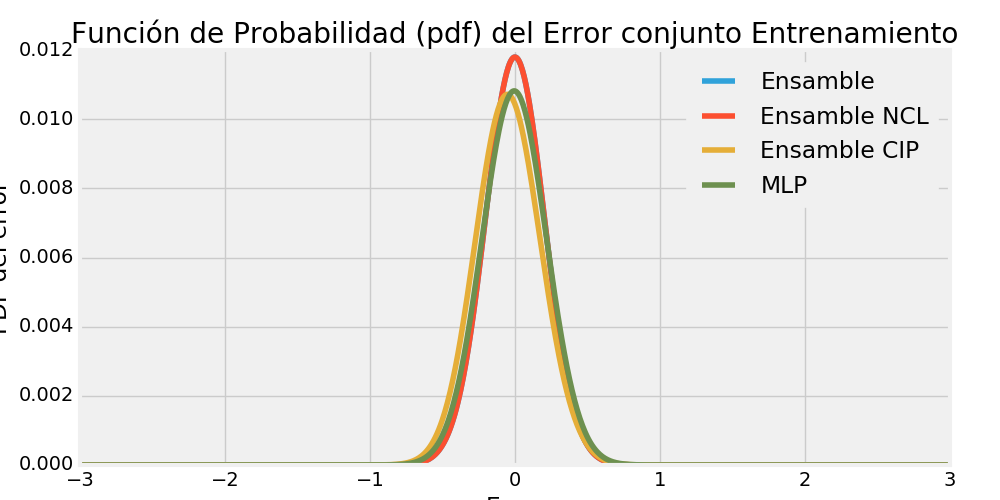

In [10]:
from sklearn.neighbors.kde import KernelDensity

def plot_pdf_error(pred, target, label_plot, ax, fig, n_points=1000, xmin=-3, xmax=3):
    error = pred - target
    N = len(error)
    s = 1.06 * np.std(error) / np.power(N, 0.2)  # Silverman
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde.fit(error)
    x_plot = np.linspace(xmin, xmax, n_points)[:, np.newaxis]
    y_plot = np.exp(kde.score_samples(x_plot))
    ax.plot(x_plot, y_plot / np.sum(y_plot), label=label_plot)
    
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_train), y_train, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_train), y_train, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_train), y_train, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_train), y_train, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()



<IPython.core.display.Javascript object>


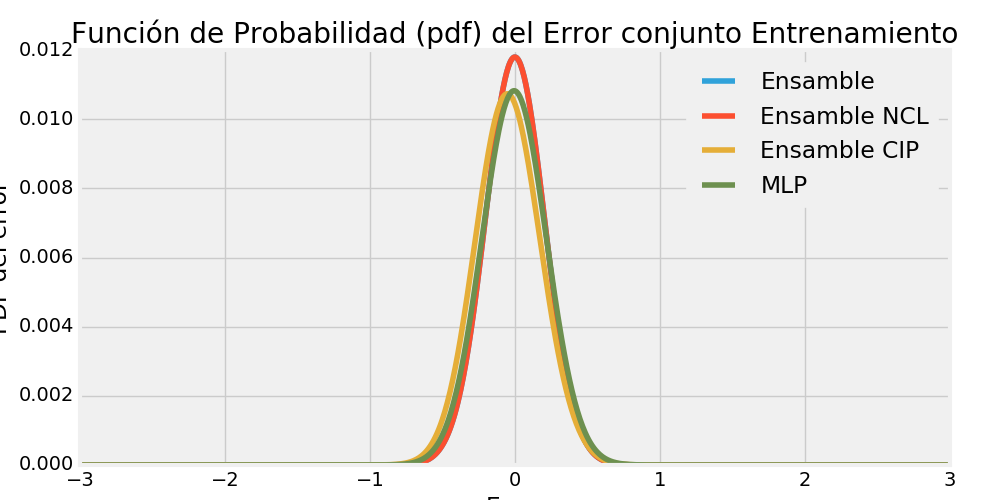

In [11]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error(ensemble.predict(X_test), y_test, 'Ensamble', ax, fig)
plot_pdf_error(ensembleNCL.predict(X_test), y_test, 'Ensamble NCL', ax, fig)
plot_pdf_error(ensembleCIP.predict(X_test), y_test, 'Ensamble CIP', ax, fig)
plot_pdf_error(mlp.predict(X_test), y_test, 'MLP', ax, fig)

plt.xlabel('Error')
plt.ylabel('PDF del error');
plt.title("Función de Probabilidad (pdf) del Error conjunto Entrenamiento")
plt.legend()